### Local County Covid Risk Estimation

This method calculates the risk at least one event attendie has COVID-19 based on the event size and prevelence of COVID in each specific county.


Pros:
 - Provides specific risk for events based on easily knowable factors and helps you choose if you should attend or not
 - Accounts for a range of detection rates
 
Cons:
 - detection rate range is large
 - does not account for demographics, like age

Assumptions:
 - only the "new cases" from the last 14 days are contagious and out walking around
 - lax or no social distancing or masks at event
 - 30% infection rate
 - exposure to everyone at event
 
### Libraries and Functions:
 

In [1]:
from IPython.core.display import display, HTML
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import pandas as pd
%matplotlib inline
INPUT_FILE = "covid-19-data/us-counties.csv"

### Data and constant variables
Using the covid dataset compiled by NYT:  
https://github.com/nytimes/covid-19-data.git


In [2]:
df = pd.read_csv(INPUT_FILE)
print(df.info())
df.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 313348 entries, 0 to 313347
Data columns (total 6 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   date    313348 non-null  object 
 1   county  313348 non-null  object 
 2   state   313348 non-null  object 
 3   fips    310087 non-null  float64
 4   cases   313348 non-null  int64  
 5   deaths  313348 non-null  int64  
dtypes: float64(1), int64(2), object(3)
memory usage: 14.3+ MB
None


,fips,cases,deaths
count,310087.000000,313348.000000,313348.000000
mean,30155.032220,503.170848,26.736542
std,15317.343588,4143.071551,359.555266
min,1001.000000,0.000000,0.000000
25%,18101.000000,6.000000,0.000000
50%,29081.000000,30.000000,1.000000
75%,45053.000000,146.000000,4.000000
max,56045.000000,222723.000000,22719.000000


### Find a specific county ID

In [3]:
find_location = "District of "
locations = df[df.county.str.contains(find_location, regex=False)]
locations = locations[["county","state","fips"]].drop_duplicates()
locations

,county,state,fips
682,District of Columbia,District of Columbia,11001.0


In [4]:

Counties = [11001]          # just dc for now
pop_est = 705749            # Population est. based on 2019 wikipedia data, if you use multiple counties, this
                            # needs to change to the total sum of all of their populations

detection_rate_lo = 0.06    # Based on case detection rates from https://www.covid19.uga.edu/parameters.html (q)
detection_rate_hi = 0.15    # and https://www.covid19.uga.edu/nowcast.html (ascertainment rate)


infection_risk = 0.30       # The risk of infection from exposure to a contagious person. (estimated based on Rt)
                            # Exposure defined as at least 15 minutes, within 6 ft, without a mask
                            # Sources  for 30%: TBD
                            # Sources for Rt:
                            # https://www.sciencedirect.com/science/article/pii/S246804272030004X
                            # https://mathematicsinindustry.springeropen.com/articles/10.1186/s13362-020-00083-3
                            # https://www.thelancet.com/pdfs/journals/eclinm/PIIS2589-5370(20)30098-5.pdf

In [5]:
 df = df[df["fips"].isin(Counties)]

In [6]:
df["delta"] = df.cases.diff()
df.head()

,date,county,state,fips,cases,deaths,delta
682,2020-03-07,District of Columbia,District of Columbia,11001.0,1,0,NaN
778,2020-03-08,District of Columbia,District of Columbia,11001.0,1,0,0.0
895,2020-03-09,District of Columbia,District of Columbia,11001.0,4,0,3.0
1030,2020-03-10,District of Columbia,District of Columbia,11001.0,4,0,0.0
1199,2020-03-11,District of Columbia,District of Columbia,11001.0,10,0,6.0


### Cases Over Time:
New cases each day over time for the areas

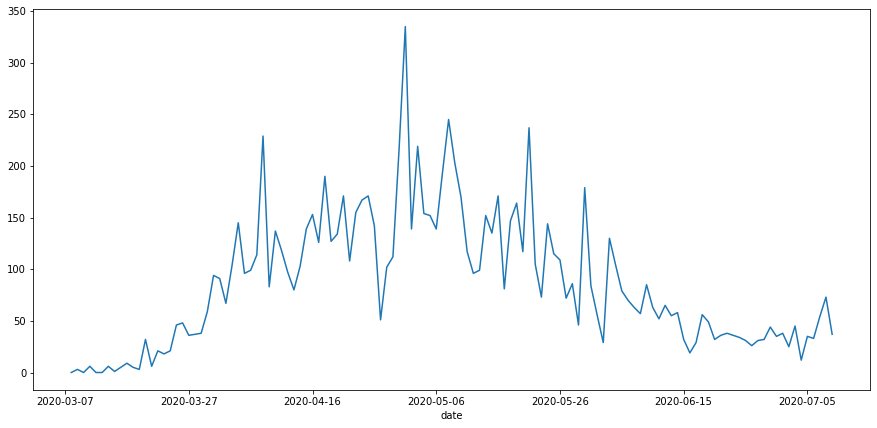

In [7]:
df.set_index('date', inplace=True)
fig, ax = plt.subplots(figsize=(15,7))
df['delta'].plot(ax=ax)


### Basic Stats:


In [8]:
newest_cases = df.tail(14)["delta"].sum()
newest_cases
## New cases over the last two weeks

520.0

In [9]:
true_best = float(newest_cases) / detection_rate_hi
true_worst= float(newest_cases) / detection_rate_lo
true_worst # inflated to the true number of new cases, based on the detection rate worst case scenario

8666.666666666668

In [10]:
true_best #inflated to the true number of new cases, based on the detection rate worst case scenario

3466.666666666667

In [11]:
percent_worst = true_worst / float(pop_est) 
percent_best  = true_best / float(pop_est)
percent_worst # The worse canse scenario chance a single person in the area is contagious

0.012280097692900263

### General Event Risk
...based on the event size and community prevelance
As the number of people at the event increases the chances that someone contagious attends increases exponentially. This image shows the risk of attending an event based on nationwide statistics from March (as an illustrated example).

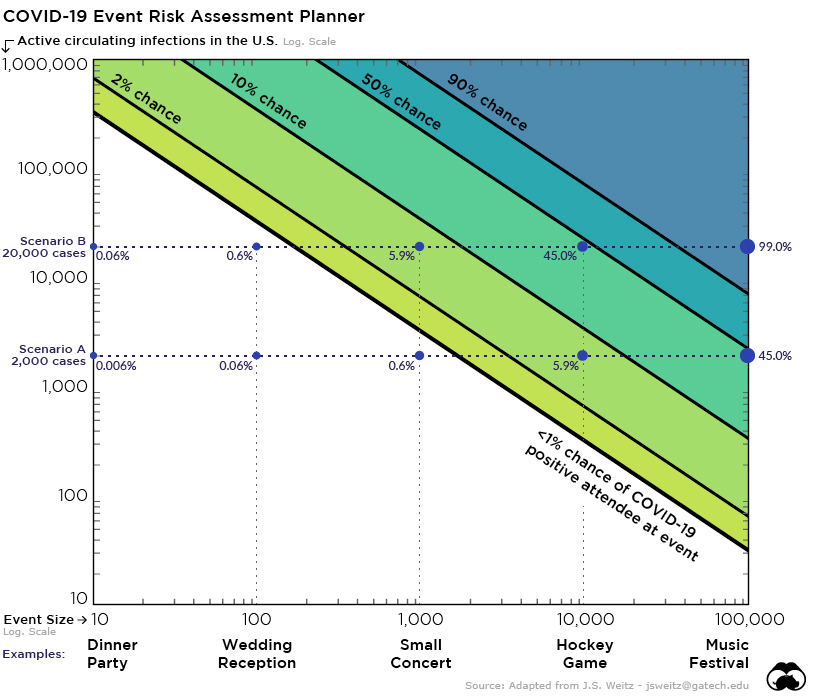

But although the number of people in attendance is the most powerful variable, risk varies widely by location but the risk one individual will be sick follows the same formula:  

Risk(at least one individual being sick) =1-(1-p)^n  
where p is prevalence (in terms of a probability) and n is the event size.  

## What are the chances someone at my event, in my city will be contagious?
This table shows the risk an attendie will attend an event in the selected local area.  

This caclulation method based off of: https://github.com/jsweitz/covid-19-event-risk-planner
by Joshua S. Weitz

In [12]:
del  locations
risk = pd.DataFrame()
risk["event_size"] = list(range(1,1000))
risk["exposure_worst_case"]  = risk.event_size.apply(lambda f : 1.0 - (1.0 - percent_worst)**float(f) )
risk["exposure_best_case"]   = risk.event_size.apply(lambda f : 1.0 - (1.0 - percent_best)**float(f) )
risk["infection_worst_case"] = risk.exposure_worst_case.apply(lambda f : float(f) * infection_risk)
risk["infection_best_case"]  = risk.exposure_best_case.apply(lambda f :float(f) * infection_risk)

# clean up sigfigs, formatting, and display output
show_me = [1,2,3,4,5,6,7,8,10,15,20,25,50,75,100,200]
risk[risk.event_size.isin(show_me)]

output = risk[risk.event_size.isin(show_me)].to_html(formatters={
     'exposure_worst_case': '{:,.2%}'.format,
    'exposure_best_case': '{:,.2%}'.format,
    'infection_worst_case': '{:,.2%}'.format,
    'infection_best_case' : '{:,.2%}'.format
})
display(HTML(output))


,event_size,exposure_worst_case,exposure_best_case,infection_worst_case,infection_best_case
0,1,1.23%,0.49%,0.37%,0.15%
1,2,2.44%,0.98%,0.73%,0.29%
2,3,3.64%,1.47%,1.09%,0.44%
3,4,4.82%,1.95%,1.45%,0.59%
4,5,5.99%,2.43%,1.80%,0.73%
5,6,7.15%,2.91%,2.14%,0.87%
6,7,8.29%,3.39%,2.49%,1.02%
7,8,9.41%,3.86%,2.82%,1.16%
9,10,11.62%,4.80%,3.49%,1.44%
14,15,16.92%,7.12%,5.08%,2.14%


## How about next weekend?

Using the last 7 days, predict the next seven days, crudely

In [13]:

trend = df.tail(7)["delta"].mean()
proj = df.tail(4)["delta"].sum() + trend*7.0
proj # projected number of people infected next week

486.0

In [14]:
true_worst= float(proj) / detection_rate_lo
percent_worst = true_worst / float(pop_est) 
percent_worst

0.011477168228364476

In [15]:
risk = pd.DataFrame()
risk["event_size"] = list(range(1,1000))
risk["worst_case"] = risk.event_size.apply(lambda i : 1.0 - (1.0 - percent_worst)**float(i) )


In [16]:

risk[risk.event_size.isin(show_me)]

,event_size,worst_case
0,1,0.011477
1,2,0.022823
2,3,0.034038
3,4,0.045124
4,5,0.056084
5,6,0.066917
6,7,0.077626
7,8,0.088212
9,10,0.109022
14,15,0.158991


In [17]:
risk.head()

,event_size,worst_case
0,1,0.011477
1,2,0.022823
2,3,0.034038
3,4,0.045124
4,5,0.056084
